<a href="https://colab.research.google.com/github/raulbenitez/IWANN21/blob/main/MNIST_Eigenfaces_vs_deepfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Traditional Machine Learning approach

Use PCA to extract features and a simple supervised classifier to classify images

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


PCA to explain 95% of the variance in the training set:

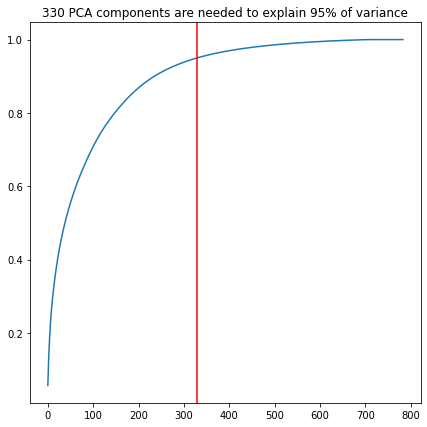

The PCA training set has dimensions 60000 330


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


# Reshape as NOBSERVATIONS x NPIXELS:
train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])


# Scale (Standardization)
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)

pca_full = PCA(n_components=test.shape[1])
pca_full.fit(train)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(7,7))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca95 = PCA(n_components=Ncomponents_95)
pca_train = pca95.fit_transform(train)
pca_test = pca95.fit_transform(test)

print('The PCA training set has dimensions {} {}'.format(*pca_train.shape))

## Visualize PCA features of the test subset using t-SNE


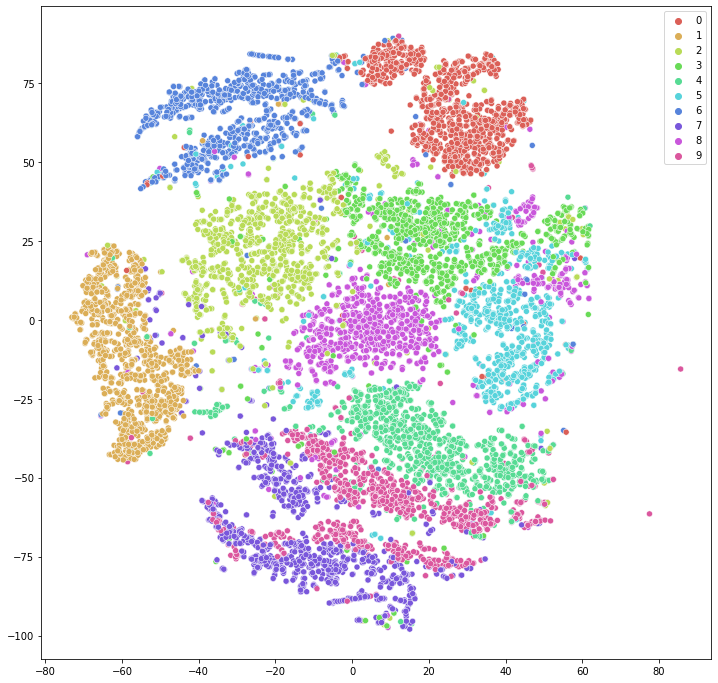

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=0)
tsne_pca = tsne.fit_transform(pca_test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

# Fit a kNN classifier using PCA features:

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2) # load the model
knn.fit(pca_train,y_train) # fit the model using training data 
y_test_pred = knn.predict(pca_test) # model prediction of test data

In [6]:
print(confusion_matrix(y_test, y_test_pred))

[[ 750   11   11   49   30   59   14    4   23   29]
 [  10 1100    2    3    6    5    2    3    2    2]
 [ 124  145  297   61  188   16   97    9   85   10]
 [ 100  114  101  400   14  118    8    7  145    3]
 [  34   52   24   19  553   11   13   66   74  136]
 [  75   98   56  203   48  181   11   89  113   18]
 [ 144   30   55   15   88   34  574    3   13    2]
 [   4  133   42  107  114   16    1  481   35   95]
 [  49   35   66  314  122   62    3   39  193   91]
 [  10   19   29   20  411   82    1  219   36  182]]


In [7]:
from sklearn.metrics import classification_report

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
print(classification_report(y_test, y_test_pred, target_names=label_names))

              precision    recall  f1-score   support

        zero       0.58      0.77      0.66       980
         one       0.63      0.97      0.77      1135
         two       0.43      0.29      0.35      1032
       three       0.34      0.40      0.36      1010
        four       0.35      0.56      0.43       982
        five       0.31      0.20      0.25       892
         six       0.79      0.60      0.68       958
       seven       0.52      0.47      0.49      1028
       eight       0.27      0.20      0.23       974
        nine       0.32      0.18      0.23      1009

    accuracy                           0.47     10000
   macro avg       0.45      0.46      0.44     10000
weighted avg       0.46      0.47      0.45     10000



## Classification using Deep Features

Use a pre-trained CNN architecture to extract deep features

## Pre-processing MNIST data to be used with a CNN architecture

Convert training and test subsets in 3-channel images

In [12]:
x_train3 = np.dstack([train] * 3)
x_test3 = np.dstack([test]*3)
x_train3.shape,x_test3.shape

((60000, 784, 3), (10000, 784, 3))

Reshape images images in tensor format required by tensorflow

In [13]:
# Reshape images as per the tensor format required by tensorflow
train_X = x_train3.reshape(-1, 28,28,3)
test_X= x_test3.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

Resize the images 48*48 as required by VGG16 architecture

In [14]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

Normalise the data and change data type to float


In [15]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

Preprocess the input 


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_X = preprocess_input(train_X)
test_X  = preprocess_input(test_X)

Instantiate the VGG16 model pre-trained with imagenet database. We load only the layers corresponding to the feature extraction and skip the last fully connected layers for classification (include_top=False). 


In [16]:
from tensorflow.keras.applications.vgg16 import VGG16

# Parameters:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# model:
model = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Extract deep features:

In [18]:
# Extracting features
train_deep_features = model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_deep_features = model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
train_deep_features.shape,test_deep_features.shape

625/625 [==============================] - 155s 247ms/step


((60000, 1, 1, 512), (10000, 1, 1, 512))

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.savez("/content/drive/MyDrive/train_feat", train_deep_features, train_X)
np.savez("/content/drive/MyDrive/test_feat", test_deep_features, test_X)